<a href="https://colab.research.google.com/github/NimaZah/Partisan-language/blob/main/partisan_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook will cover:   

1.   how to train a gensim model on a text corpus
2.   how to extend the model to new
3.   how to use the model to measure political phenomena.

The Congressional Record, which documents all speeches delivered on the floor of the United States Congress, serves as the sample corpus for our experiments (already processed.)

In [2]:
import numpy as np
import pandas as pd
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import urllib.request
import shutil
import os
import random
from copy import deepcopy

In [114]:
def stream_data(link_to_file, local_file):
    """link_to_file: the link to the file that you want to download
    local_file: the name of the local file where you want to store the downloaded file

    The function returns a list of lists
    """

    # Expected to return a list of lists or an iterable of that kind
    # (maybe try gensim's LineSentence)
    if not os.path.exists(local_file):
        with urllib.request.urlopen(link_to_file) as response, open(
            local_file, "wb"
        ) as out_file:
            shutil.copyfileobj(response, out_file)

    corpus = LineSentence(local_file)
    return corpus

In [136]:
url = 'https://raw.githubusercontent.com/NimaZah/comparing-word2vec-models/main/data/cr_subset.txt'
local_file = 'cr_subset.txt'
corpus = stream_data (link_to_file=url, local_file=local_file)

In [116]:
window_sizes = [2, 10, 50]
models = list ()
for window_size in window_sizes:
  model = Word2Vec (corpus, window=window_size, seed=42, workers=1)
  models.append (model)

In [118]:
query = 'running'
for i in range (len (window_sizes)):
  window_size = window_sizes[i]
  model = models[i]
  print (f'Model context window size={window_size}')
  for item in model.wv.most_similar(query, topn=5):
    print (item)
  print ()

Model context window size=2
('handing', 0.6530050039291382)
('holding', 0.6426299810409546)
('locked', 0.6414072513580322)
('crying', 0.6401162147521973)
('ran', 0.632382869720459)

Model context window size=10
('run', 0.6682204604148865)
('ran', 0.6315473914146423)
('laying', 0.6200999021530151)
('throwing', 0.617172122001648)
('turns', 0.6019847989082336)

Model context window size=50
('run', 0.5537126064300537)
('roof', 0.5162860155105591)
('ran', 0.5064026713371277)
('busy', 0.48873621225357056)
('pinch', 0.4767358899116516)



In [119]:
min_counts = [10, 25]
models = list()
for min_count in min_counts:
    model = Word2Vec(corpus, min_count=min_count, seed=42, workers=1)
    models.append(model)

In [120]:
query = "running"
for i in range(len(min_counts)):
    min_count = min_counts[i]
    model = models[i]
    print(f"Model minimum count threshold={min_count}")
    for item in model.wv.most_similar(query, topn=5):
        print(item)
    print()

Model minimum count threshold=10
('pulling', 0.6407041549682617)
('locked', 0.6383042335510254)
('throwing', 0.6322669982910156)
('ran', 0.6276757717132568)
('run', 0.6180986166000366)

Model minimum count threshold=25
('pulling', 0.6583755612373352)
('run', 0.6295990347862244)
('thrown', 0.6165142059326172)
('locked', 0.6064479351043701)
('pulled', 0.5974926352500916)



In [121]:
def w2v_to_numpy (model):
  """ it takes the word2vec model
and converts it into a numpy array. The embeddings are the rows of the array.
The mapping of words to the row numbers are stored in the idx dictionary.
  """ 
  model.wv.init_sims()
  embeddings = deepcopy (model.wv.vectors_norm)
  idx = {w:i for i, w in enumerate (model.wv.index2word)}
  iidx = {i:w for i, w in enumerate (model.wv.index2word)}
  return embeddings, (idx, iidx)

In [122]:
model = Word2Vec (corpus, min_count=10, window=10, seed=42, workers=1)
embs, (idx, iidx) = w2v_to_numpy (model)

In [123]:
def near_neighbors (embs, query, word2rownum, rownum2word, k=5):
  """ it takes a word embedding matrix and a word and finds the nearest neighbors for that word.
  """

  sims = np.dot (embs, embs[word2rownum[query]])  
  indices = np.argpartition (-sims, k)[:k]
  return [(rownum2word[index], sims[index]) for index in indices]

In [124]:
for nbor, sim in near_neighbors (embs, query, idx, iidx, k=5):
  print (nbor, sim)

running 1.0
run 0.61950654
turned 0.61326796
ran 0.61322933
throwing 0.60495627


In [125]:
for item in model.wv.most_similar(query, topn=5):
  print (item)

('run', 0.6195065379142761)
('turned', 0.6132679581642151)
('ran', 0.6132293343544006)
('throwing', 0.6049562692642212)
('pulling', 0.5896352529525757)


In [132]:
# split the corpus into two separate corpora, based on political party.
url = "https://raw.githubusercontent.com/NimaZah/comparing-word2vec-models/main/data/cr_dem_subset.txt"
local_file = "cr_dem_subset.txt"
dem_corpus = stream_data(link_to_file=url, local_file=local_file)
url = "https://raw.githubusercontent.com/NimaZah/comparing-word2vec-models/main/data/cr_rep_subset.txt"
local_file = "cr_rep_subset.txt"
rep_corpus = stream_data(link_to_file=url, local_file=local_file)

In [22]:
# train a word2vec model on each corpus
dem_model = Word2Vec(dem_corpus, min_count=10, window=10, seed=42, workers=1)
rep_model = Word2Vec(rep_corpus, min_count=10, window=10, seed=42, workers=1)

# convert the models to numpy arrays
dem_embs, (dem_idx, dem_iidx) = w2v_to_numpy(dem_model)
rep_embs, (rep_idx, rep_iidx) = w2v_to_numpy(rep_model)

In [126]:
# find the nearest neighbors for the query word in each model / Example of query: 'liberty'
query = "liberty"
print("Democratic model")
for nbor, sim in near_neighbors(dem_embs, query, dem_idx, dem_iidx, k=5):
    print(nbor, sim)
print()
print("Republican model")
for nbor, sim in near_neighbors(rep_embs, query, rep_idx, rep_iidx, k=5):
    print(nbor, sim)
print()

Democratic model
liberty 1.0000001
freedoms 0.8226675
democracy 0.7586901
freedom 0.747592
equality 0.74588585

Republican model
liberties 0.87058973
religion 0.8144254
freedom 0.8691087
liberty 1.0
freedoms 0.8590754



In [137]:
def procrustes(A, B):
    """
    align matrix A and B
    
    """
    
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def vocab_intersection (idx1, idx2):

  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)},
  {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_mat(mat1, mat2, idx1, idx2):

    common_vocab, (common_idx, common_iidx) = vocab_intersection(idx1, idx2)
    row_nums1 = [idx1[v] for v in common_vocab]
    row_nums2 = [idx2[v] for v in common_vocab]

    # print (len(common_vocab), len (common_idx), len (common_iidx))
    remapped_mat1 = mat1[row_nums1, :]
    remapped_mat2 = mat2[row_nums2, :]
    # print (mat1.shape, mat2.shape, remapped_mat1.shape, remapped_mat2.shape)
    omega = procrustes(remapped_mat1, remapped_mat2)
    # print (omega.shape)
    # rotated_mat2 = np.dot (omega, remapped_mat2)
    rotated_mat2 = np.dot(remapped_mat2, omega)

    return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

In [139]:
query = "taxes"
print("Democratic model")
for nbor, sim in near_neighbors(dem_aligned, query, common_idx, common_iidx, k=5):
    print(nbor, sim)
print()
print("Republican model")
for nbor, sim in near_neighbors(rep_aligned, query, common_idx, common_iidx, k=5):
    print(nbor, sim)
print()

Democratic model
taxes 0.99999994
income 0.77295697
wealthy 0.75138724
subsidies 0.7358136
billionaires 0.72880197

Republican model
tax 0.7408292
taxes 0.9999998
income 0.69876194
revenue 0.6654221
wage 0.624496



In [130]:
words = [
    "liberty",
    "freedom",
    "war",
    "peace",
    "religion",
    "equality",
    "abortion",
    "taxes",
]

for word in words:
    print(word)
    print("Democratic model")
    for nbor, sim in near_neighbors(dem_aligned, word, common_idx, common_iidx,
                                    k=5):
        print(nbor, sim)
    print()
    print("Republican model")
    for nbor, sim in near_neighbors(rep_aligned, word, common_idx, common_iidx,
                                    k=5):
        print(nbor, sim)
    print()

liberty
Democratic model
liberty 1.0000001
freedoms 0.8226675
democracy 0.7586901
freedom 0.747592
equality 0.74588585

Republican model
freedom 0.8691087
freedoms 0.85907555
liberty 1.0000001
liberties 0.87058973
religion 0.8144255

freedom
Democratic model
freedom 0.99999994
liberty 0.747592
freedoms 0.7330756
expression 0.758657
democracy 0.7207771

Republican model
freedom 0.9999998
liberty 0.8691087
democracy 0.7923656
freedoms 0.78945506
liberties 0.7836131

war
Democratic model
war 1.0000002
iraq 0.7915003
afghanistan 0.73059285
wars 0.69578314
vietnam 0.6679038

Republican model
vietnam 0.6732739
war 0.9999999
iraq 0.6865439
cold 0.69772625
terror 0.6673112

peace
Democratic model
peace 0.9999999
peaceful 0.78667367
israel 0.74349546
nato 0.70759207
diplomacy 0.6995456

Republican model
victory 0.7475169
strength 0.7937141
peace 1.0
terror 0.7215583
gods 0.71189296

religion
Democratic model
ethnicity 0.79400337
beliefs 0.7579537
religion 0.9999999
religious 0.79181486
hatred 0

In [140]:
# Compute what are the top 5 words that are most associated with the Democratic party?

dem_sims = np.dot(dem_aligned, dem_aligned.T)
rep_sims = np.dot(rep_aligned, rep_aligned.T)

dem_sims_sum = np.sum(dem_sims, axis=1)
rep_sims_sum = np.sum(rep_sims, axis=1)

dem_sims_sum_indices = np.argpartition(-dem_sims_sum, 5)[:5]
rep_sims_sum_indices = np.argpartition(-rep_sims_sum, 5)[:5]

print("Democratic model")
for index in dem_sims_sum_indices:
    print(common_iidx[index], dem_sims_sum[index])
print()
print("Republican model")
for index in rep_sims_sum_indices:
    print(common_iidx[index], rep_sims_sum[index])
print()


Democratic model
counsels 3677.6118
alaskan 3677.7344
spc 3705.5952
expeditionary 3827.8792
commanded 3673.6338

Republican model
paramount 3913.963
computing 3958.2136
mitchell 3887.5828
raymond 3886.4995
jan 3834.2212



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


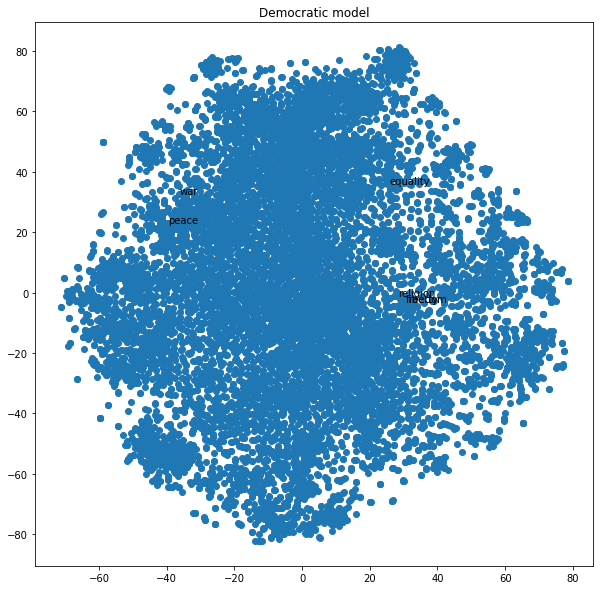

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


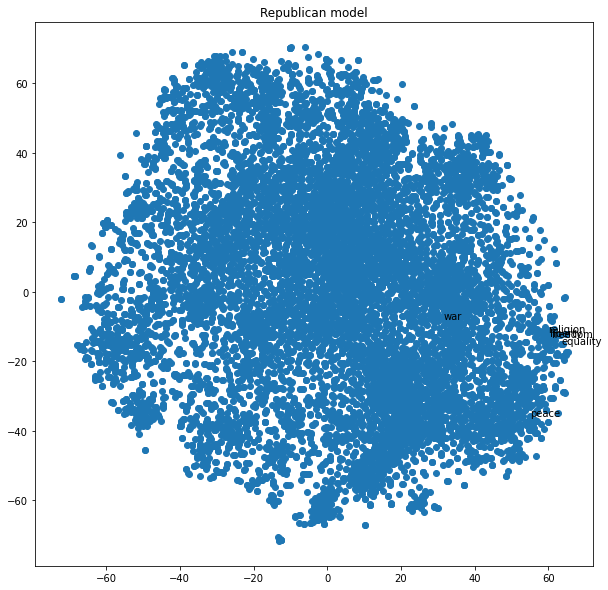

In [141]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pickle


def tsne_plot(embs, idx, iidx, words, title):
    """
    embs: the embedding matrix
    idx: the mapping of words to row numbers
    iidx: the mapping of row numbers to words
    words: the list of words to plot
    title: the title of the plot
    """

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(embs)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    for word in words:
        plt.annotate(word, (X_tsne[idx[word], 0], X_tsne[idx[word], 1]))
    plt.show()


words = ["liberty", "freedom", "war", "peace", "religion", "equality"]

tsne_plot(dem_aligned, common_idx, common_iidx, words, "Democratic model")
tsne_plot(rep_aligned, common_idx, common_iidx, words, "Republican model")


In [142]:
# Visualize the two models using t-SNE

from sklearn.manifold import TSNE


def tsne_plot(model, word2rownum, rownum2word, words):
    """
    Create TSNE model and plot it
    """
    labels = []
    tokens = []

    for word in words:
        tokens.append(model[word2rownum[word]])
        labels.append(word)

    tsne_model = TSNE(
        perplexity=40, n_components=2, init="pca", n_iter=2500, random_state=23
    )
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(
            labels[i],
            xy=(x[i], y[i]),
            xytext=(5, 2),
            textcoords="offset points",
            ha="right",
            va="bottom",
        )
    plt.show()

In [143]:
words = [
    "liberty",
    "freedom",
    "war",
    "peace",
    "religion",
    "equality",
    "god",
    "america",
    "constitution",
    "president",
    "congress",
    "senate",
    "house",
    "law",
    "tax",
    "democrat",
    "republican",
    "election",
    "campaign",
    "vote",
    "ballot",
    "judge",
    "justice",
    "police",
    "crime",
    "prison",
    "jail",
    "gun",
    "firearm",
    "weapon",
    "school",
    "university",
    "college",
    "students",
    "economy",
    "market",
    "trade",
    "currency",
    "business",
    "company",
    "job",
    "work",
    "employee",
    "boss",
    "salary",
    "wage",
    "income",
    "pay",
    "spend",
    "buy",
    "sell",
    "loan",
    "debt",
    "bank",
    "insurance",
    "doctor",
    "health",
    "care",
    "hospital",
    "medicine",
    "pharmacy",
    "drug",
    "pill",
    "vaccine",
    "attack",
    "cancer",
    "disease",
    "illness",
]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


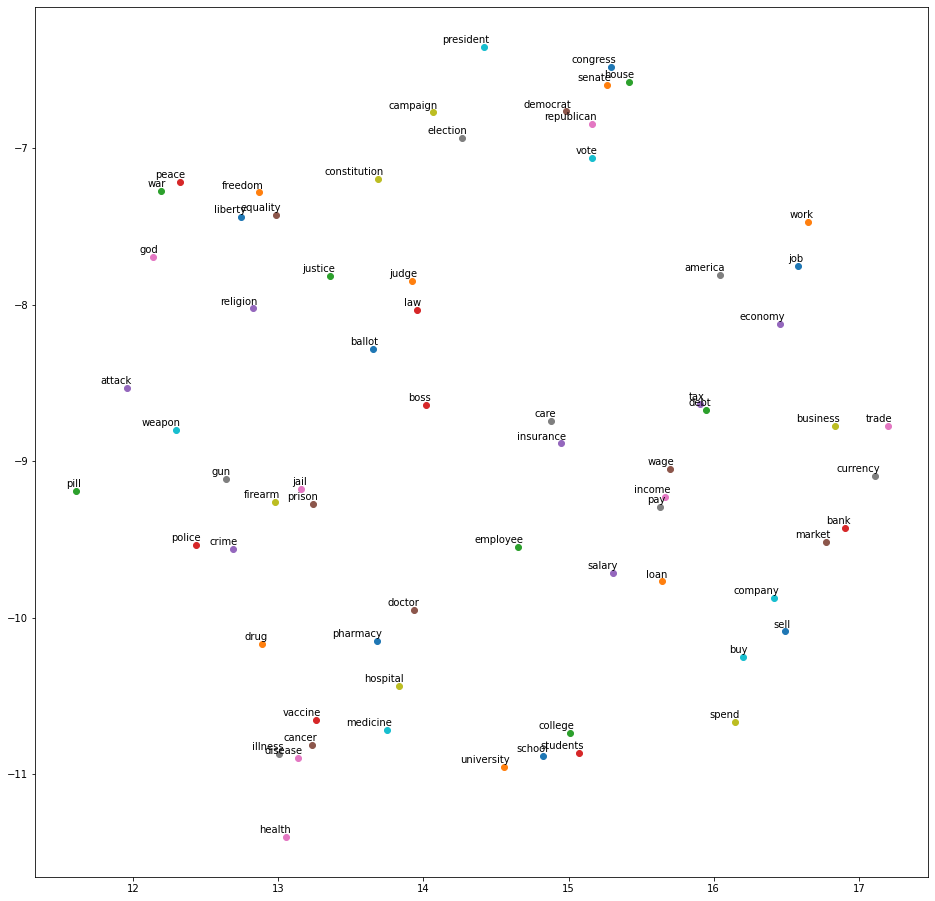

In [103]:
tsne_plot(dem_aligned, common_idx, common_iidx, words)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


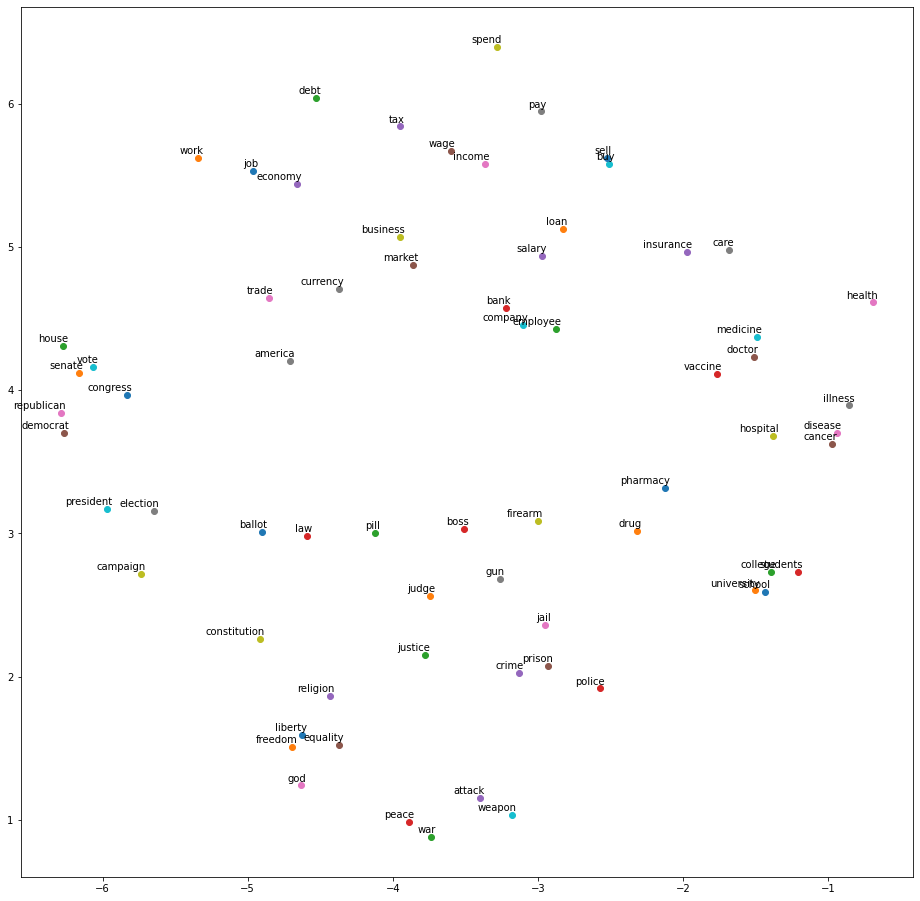

In [104]:
tsne_plot(rep_aligned, common_idx, common_iidx, words)